# Week 4: Introduction to deep learning

**Created**: 03/10/2022  
**Author**: Gareth Harman  
**Entity**: ReproNim 

### Module Imports

In [1]:
# Data prep and helpers
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split
from tqdm import tqdm 
import os

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
import torchvision

# Additional helper functions
import week_4_helperFx as fx

# Lets create some challenging data to model

- Here we are going to generate spiral data 
- We will have two classes (binary classfication)

- How difficult might these decision boundaries be to classify?
  > Impossible with linear models. Tricky but possible with non-linear models.
- How much noise before you feel YOU would struggle to draw a clean boundary line?
  > Beyond about 1.5 noise, the spirals overlap significantly.

<AxesSubplot:xlabel='x', ylabel='y'>

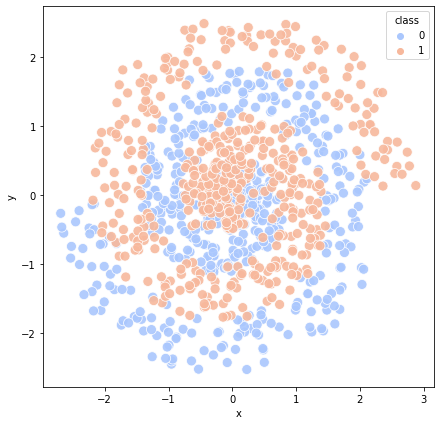

In [14]:
# Generate some data and return the pandas dataframe
num_obs = 1000
num_spiral = 4
noise_amt = 1.6

X, y, df = fx.generateSpiral(num_obs, num_spiral=num_spiral, noise=noise_amt)

# Plot the data and use color to view classes
fig, ax = plt.subplots(figsize = (7, 7))
sns.scatterplot(x='x', y='y', hue='class', palette='coolwarm',
                data=df, s=100, alpha=.9)

# Pytorch: Working with data

### PyTorch Tensors

- It is likely most of us are familiar with using numpy arrays 
- PyTorch requires the use of `torch.tensors`
- **Both of these objects are matrices**
- But `torch.tensors` have two important attributes

**`.requires_grad`**
- If `True`, this attribute lets us know whether we should keep track and calculate gradients for this tensor

**`.to()`**
- This function allows us to send objects to different devices (i.e., CPU or GPU)
- Additionally, we can use this function to cast a tensor to a data type


In [17]:
# Create a random numpy array
z = np.random.rand(50, 50)

# Recast this to a tensor
z = torch.tensor(z, dtype=torch.float)

# Check if this tensor is going to keep track of the gradient
print(z.requires_grad)

False





## PyTorch Dataset

Adapted from pytorch's documentation [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

```python
from torch.utils.data import Dataset, DataLoader
```

From the pytorch documentation 

> The `Dataset` object retrieves our dataset’s features and labels one sample at a time


- Many existing datasets such as `MNIST` or `Fashion-MNIST` have functions for downloading and loading
- However, more commonly we will want to create our own **custom** dataset
- To create our own dataset class we are required to include the following three class methods 

```python
class MyDataset:
```

```python

    __init__(self, X, y):
        self.X = X
        self.y = y
        
```

- This function is just the normal python class initialization method
- In this exercise we are feeding our data in directly, but another common scenario may be reading in some .csv that contains columns for `subjectid`, `outcome`, and `image_path` 

```python

    __len__(self):
        return len(self.y)
        
```

- This function's sole duty is to return the number of observations in the dataset

```python

    __getitem___(self, idx):
        return self.X[idx], self.y[idx]
        
```

- This function is the bulk of the custom dataset class
- This method simply obtains a single observation from our data given an index 
- While this logic is required in all `__getitem__` methods, they typically contain additional elements
- For example, with imaging data this function may simply index a specific row in our earlier mentioned .csv to get our `subjectid`, `outcome`, and `image_path`
- We would then also load our imaging data given the `image_path` 
- Additionally we could apply some other operations (such as min-max scaling) in here

**Note**:

- This method is called **MANY** times during the training of our model so if we are doing additional operations we may want to keep them minimal
- We can use python's `multiprocessing` to help speed this up
- Additionally, when working with niftis I have found that using another script to load and then saving the niftis as `torch.tensors` to be much more efficient. The `torch.load()` is much faster than say `nibabel.load()`

In [2]:
class MyDataset(Dataset):

    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float)
        self.y = torch.tensor(y, dtype=torch.float)
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


## DataLoaders

- The **reason** why we create the pytorch Dataset
- This object allows us to easily iterate through batches of our data to train our model

Again, from the pytorch documentation

> `DataLoader` is an iterable that abstracts this complexity for us in an easy API.

- Most frequently we update our weights in batches, both to introduce stochasisticity and overcome memory limitations 
- PyTorch has a built in data object called a `DataLoader`

If youre at all planning to use the dataloader I highly recommend reading the documentation [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

1. Create a new batch of data with the given parameters
2. Split the data into train/test sets
3. Create the train/test Datasets using our custom `MyDataset` class
4. Create the `DataLoader` object using our custom dataset

In [3]:
# Generate some spiral data
X, y, df = fx.generateSpiral(750, 4, noise=1.25)

# Split into train and test
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.33, random_state=42)

# We first create datasets of our custom dataset class for train/test
tr_data = MyDataset(X_tr, y_tr)
te_data = MyDataset(X_te, y_te)

# Now create the instances of the train/test loaders
tr_loader = DataLoader(tr_data, batch_size=50, shuffle=True)
te_loader = DataLoader(te_data, batch_size=50, shuffle=True)

## PyTorch nn.Module and Sequential

Below we will create a simple 4 layer neural network

### Creating the network: Option 1 (manual)

- With this option we must explicitly define our layers and order of operations in our forward pass
- Additionally we **must** define a `forward()` call

In [4]:
class NetOpt1(nn.Module):
    
    def __init__(self, act):
        nn.Module.__init__(self)
        
        # The activation function of our choosing
        self.act = act
        
        # Network instantiation
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 1)
        self.sig = nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.act(x)
        x = self.fc3(x)
        x = self.sig(x)
        return x

### Creating the network: Option 2 (with sequential)

- Sequential is nice because it assumes our data moves **in order** (as specified from the sequential)
- Additionally, we do not need to define the `forward()` function because it is assumed

In [5]:
class Net(nn.Module):
    
    def __init__(self, act):
        nn.Module.__init__(self)

        self.act = act
        
        self.model = nn.Sequential(
            # Layer 1
            nn.Linear(2, 10),
            self.act,
            
            # Layer 2
            nn.Linear(10, 10),
            self.act,
            
            # Layer 3
            nn.Linear(10, 1),
            nn.Sigmoid()
        )

### If we wanted create a neural network for a regression problem

- We would drop the last activation function (sigmoid) 
- And use MSELoss 


## This is the main function train our model

In [9]:
def train_model(train_loader, test_loader, n, criterion, lr = .001, n_epochs = 100):
    '''This function is our wrapper to create an instance and train our model.
    Note: Typically I wouldn't recommend cramming all of this in a function,
    but for ease of running multiple different parameters, here we are.
    
    Attributes:
        train_loader (DataLoader): The instance of our training dataloader
        test_loader  (DataLoader): The instance of our test dataloader
        n            (nn.Sequential): Our network object
        criterion    (DataLoader): Our loss function
        lr           (Float): Our learning rate for our optimizer
        n_epochs     (Int): The number of iterations to train for
        act          (nn.Functional): The activation function from pytorch functional
    
    Returns:
        net          Our trained network object for boundary plotting
        perf         The performance of our model
    '''
    # Store our loss both our training and test data
    perf = {'loss': [], 'type': [], 'epoch': []}
    
    # Set our optimizer
    optimizer = optim.Adam(n.parameters(), lr=lr)
    
    ###############################################
    ## Training
    ###############################################
    
    for epoch in range(n_epochs):
        
        train_loss = []; test_loss = []         # Store loss at each epoch
        
        for batch_idx, (train_x, train_y) in enumerate(tr_loader):
            
            optimizer.zero_grad()               # Zero out the gradient
            tr_pred = n.model.forward(train_x)  # Our forward pass
            
            # Calculate and store loss
            tr_loss = criterion(tr_pred.squeeze(), train_y.squeeze())
            train_loss.append(tr_loss.item())
            
            tr_loss.backward()                  # Compute our gradients
            optimizer.step()                    # Step on our loss surface
        
        ###############################################
        ## Test Evaluation
        ###############################################
        
        for batch_idx, (test_x, test_y) in enumerate(te_loader):
            
            with torch.no_grad():               # Dont store the gradient
                
                # Forward, calculate loss and store
                test_pred = n.model.forward(test_x)
                te_loss = criterion(test_pred.squeeze(), test_y.squeeze())
                test_loss.append(te_loss.item())
        
        # Update performance metrics
        perf = fx.update_perf(perf, train_loss, test_loss, epoch)
        
        if epoch % 20 == 0:
            print(f'| Epoch: {str(epoch).zfill(3)} '
                  f'| Train Loss: {tr_loss.item():.4f} '
                  f'| Test Loss: {te_loss.item():.4f} |')
    
    return n.model, pd.DataFrame(perf)


## What is happening?

---

### Zeroing the gradient

**PyTorch Documentation**: [here](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html)

```python line_num=True
 optimizer.zero_grad()
```

- We set our gradient to zero

### Forward pass

---

```python
tr_pred = n.model.forward(tr_xx)
```

- This is our forward pass 
- Data moves through our network and we get some prediction

### Weight updating

---

```python
tr_loss.backward()
optimizer.step()
```

- Here we are calling `backward()` which propagates our loss **backward** through our network
- The `step` call allows us to, well, *step* towards some potential minima on our loss surface

### Test evaluation

---

```python
with torch.no_grad():
```

- When evaluating our test data, it is not necessary to store or keep track of the gradient in any way
- These operations can be expensive both in terms of memory and computation
- With no grad is a nice easy way to set all objects with the `requires_grad` attribute to `False`

# TRAIN THE NETWORK

## Lets set up the parameters for our network

1. Pick an activation function from [here](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity)
2. Create an instance of the network
3. Set the learning rate
4. Select our loss function from [here](https://pytorch.org/docs/stable/nn.html#loss-functions)

Try the following configurations and check to see if the network will converge 

**Also try and consider why/why not this network might be converging**

Play around with different `activation fx`, `learning rate`, `number of epochs`

**First**
- Activation Function: `ReLU`
- Learning Rate: `.00001`, `1`
- Epochs: `250`

| Epoch: 000 | Train Loss: 1.4996 | Test Loss: 7.0414 |
| Epoch: 020 | Train Loss: 0.8243 | Test Loss: 0.6933 |
| Epoch: 040 | Train Loss: 0.6672 | Test Loss: 0.6992 |
| Epoch: 060 | Train Loss: 0.7284 | Test Loss: 0.6384 |
| Epoch: 080 | Train Loss: 0.7011 | Test Loss: 0.6991 |
| Epoch: 100 | Train Loss: 0.7021 | Test Loss: 0.6897 |
| Epoch: 120 | Train Loss: 0.6933 | Test Loss: 0.6775 |
| Epoch: 140 | Train Loss: 0.7043 | Test Loss: 0.6799 |
| Epoch: 160 | Train Loss: 0.7173 | Test Loss: 0.6720 |
| Epoch: 180 | Train Loss: 0.6141 | Test Loss: 0.7135 |
| Epoch: 200 | Train Loss: 0.5796 | Test Loss: 0.6818 |
| Epoch: 220 | Train Loss: 0.4524 | Test Loss: 0.7914 |
| Epoch: 240 | Train Loss: 0.6942 | Test Loss: 0.6943 |


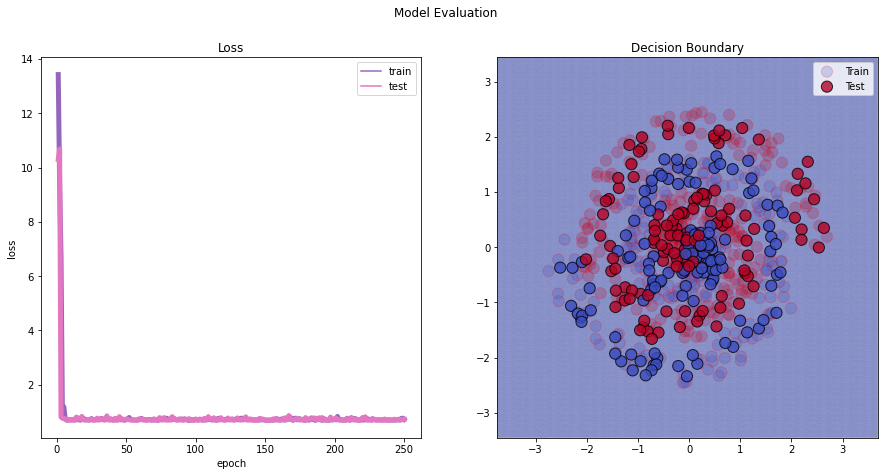

In [12]:
act = nn.ReLU()
lr = 1
n_epochs = 250

n = Net(act)
criterion = nn.BCELoss()

net, perf = train_model(tr_loader, te_loader, n, criterion, lr=lr, n_epochs=n_epochs)
fx.modPlot(X_tr, y_tr, X_te, y_te, net, perf, cmap = 'coolwarm')

**Second**
- Activation Function: `Sigmoid`
- Learning Rate: `.01`
- Epochs: `250`

| Epoch: 000 | Train Loss: 0.6925 | Test Loss: 0.6925 |
| Epoch: 020 | Train Loss: 0.4580 | Test Loss: 0.6257 |
| Epoch: 040 | Train Loss: 0.8735 | Test Loss: 0.6562 |
| Epoch: 060 | Train Loss: 0.8156 | Test Loss: 0.6808 |
| Epoch: 080 | Train Loss: 0.3743 | Test Loss: 0.6453 |
| Epoch: 100 | Train Loss: 0.5633 | Test Loss: 0.6899 |
| Epoch: 120 | Train Loss: 0.5733 | Test Loss: 0.6319 |
| Epoch: 140 | Train Loss: 0.7412 | Test Loss: 0.6041 |
| Epoch: 160 | Train Loss: 0.6002 | Test Loss: 0.6921 |
| Epoch: 180 | Train Loss: 0.5500 | Test Loss: 0.7512 |
| Epoch: 200 | Train Loss: 0.7715 | Test Loss: 0.7089 |
| Epoch: 220 | Train Loss: 0.4527 | Test Loss: 0.6463 |
| Epoch: 240 | Train Loss: 0.4372 | Test Loss: 0.6393 |


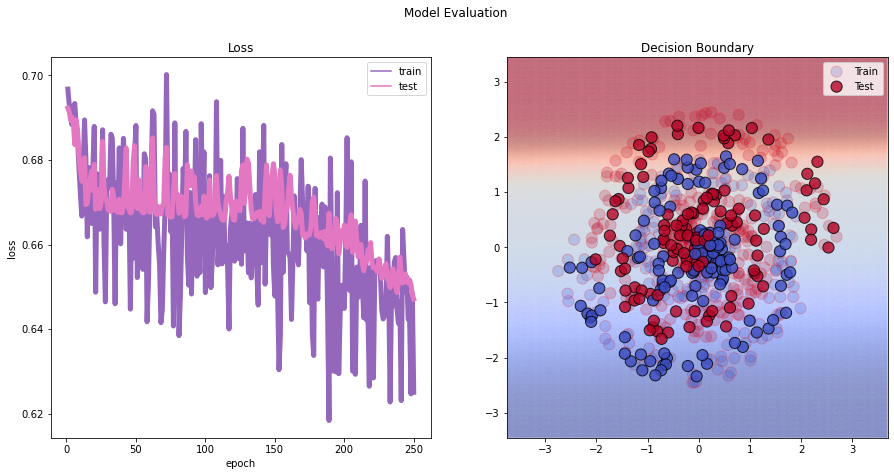

In [13]:
act = nn.Sigmoid()
lr = .01
n_epochs = 250

n = Net(act)
criterion = nn.BCELoss()

net, perf = train_model(tr_loader, te_loader, n, criterion, lr=lr, n_epochs=n_epochs)
fx.modPlot(X_tr, y_tr, X_te, y_te, net, perf, cmap = 'coolwarm')

**Third**
- Activation Function: `ReLU`
- Learning Rate: `.01`
- Epochs: `250`

| Epoch: 000 | Train Loss: 0.7086 | Test Loss: 0.6580 |
| Epoch: 020 | Train Loss: 0.4635 | Test Loss: 0.6608 |
| Epoch: 040 | Train Loss: 0.2400 | Test Loss: 0.5992 |
| Epoch: 060 | Train Loss: 0.4687 | Test Loss: 0.5568 |
| Epoch: 080 | Train Loss: 0.0072 | Test Loss: 0.4793 |
| Epoch: 100 | Train Loss: 0.7263 | Test Loss: 0.3462 |
| Epoch: 120 | Train Loss: 0.1279 | Test Loss: 0.3342 |
| Epoch: 140 | Train Loss: 0.0176 | Test Loss: 0.2630 |
| Epoch: 160 | Train Loss: 0.0216 | Test Loss: 0.2909 |
| Epoch: 180 | Train Loss: 0.2150 | Test Loss: 0.2909 |
| Epoch: 200 | Train Loss: 0.3874 | Test Loss: 0.1944 |
| Epoch: 220 | Train Loss: 0.0072 | Test Loss: 0.1759 |
| Epoch: 240 | Train Loss: 0.0222 | Test Loss: 0.2780 |


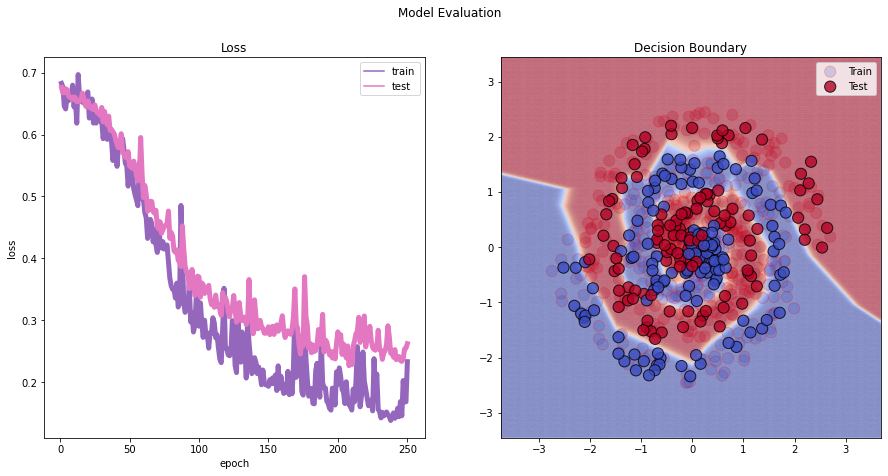

In [14]:
act = nn.ReLU()
lr = .01
n_epochs = 250

n = Net(act)
criterion = nn.BCELoss()

net, perf = train_model(tr_loader, te_loader, n, criterion, lr=lr, n_epochs=n_epochs)
fx.modPlot(X_tr, y_tr, X_te, y_te, net, perf, cmap = 'coolwarm')

## Questions

1. The `__getitem__()` function in the **PyTorch Dataset** object returns 
    - [x] A single observation
    - [ ] As many observations as specified 
    - [ ] Only the index of the observation 
    - [ ] A dict containing a reference to the correct observation


2. With the synthetic data that we are using in this example, what is the best choice for our loss function?
    - [ ] Mean squared error
    - [ ] Connectionist Temporal Classification loss
    - [x] Binary cross entropy loss
    - [ ] Kullback-Leibler divergence loss


3. How does setting the learning rate too low/high alter how our network will learn
    - Low: we take small steps and might never hit a minima
    - Large: bounce back and forth over the minima


4. Which activation functions can fit our data with this configuration
    - Tanh and ReLU fit
    - Sigmoid does not, it may be that because the gradient of the sigmoid is smaller our weight update call is slower (setting a higher learning rate fixes this)


5. What is a possible common issue we could run into using the sigmoid or tanh activation functions?
    - [ ] Network sparsity 
    - [ ] Stochastic dropout
    - [x] Gradient vanishing
    - [ ] Loss pooling
    
    
6. How is a torch.tensor different than a standar numpy.ndarray?
    - [ ] Tensor's are 64-bit complex datatype and numpy array's use 64-bit floating point
    - [x] Tensor's contain additional attributes for device casting (send to CPU/GPU) and a boolean that indicates the gradient of that tensor be calculated/stored
    - [ ] Numpy arrays are better optimized for parallel computing using a CPU
    - [ ] The two are equivalent, but PyTorch wanted a proprietary data object to please investors
    
    
7. How many `trainable` parameters does our network have?
    - [ ] 131
    - [ ] 172
    - [ ] 128
    - [x] 151


8. Let's assume that our model is overfitting (not generalizing to the test data), what might we try (check all that apply)?
    - [x] Add regularization (i.e, weight decay to the Adam optimizer)
    - [ ] Increase the number of layers in the network
    - [x] Send a lengthy email to Geoffrey Hinton and Yann LeCun
    - [x] Include dropout in each of our fully connected layers
    - [ ] Use the ELU() activation function
    - [x] Reducing the number of parameters in our network

# Convolutional Neural Networks

- Here we begin working with convolutional neural networks
- These powerful networks allow us to leverage spatial relationships in our N-dimensional space by using the convolution

**The Convolution**

$$f[x, y] * g[x, y] = \sum_{n_{1}=-\infty}^{\infty} \sum_{n_{2}=-\infty}^{\infty} f\left[n_{1}, n_{2}\right] \cdot g\left[x-n_{1}, y-n_{2}\right]$$

### Download MNIST

- This will create a `mnist` folder in your current directory and save the mnist data (`~28mb`) there
- We will also create the dataloaders
- The `transform` option in the datasets object allows us to 
    1. Convert our data into a `torch.tensor` 
    2. Apply some normalization

In [24]:
mnist_path = os.path.expanduser('~/mnist')

# Create folder for mnist if it doesnt exist
if not os.path.isdir(mnist_path):
    os.makedirs(mnist_path)

# The transform we will apply to both train/test
tform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                        torchvision.transforms.Normalize((0.1307,), (0.3081,))])

# Create the DataSet object, it will download MNIST for us
mnist_train = torchvision.datasets.MNIST(mnist_path, train=True, download=True, transform=tform)
mnist_test = torchvision.datasets.MNIST(mnist_path, train=False, download=True, transform=tform)

# Create the train/test dataloaders
mnist_train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=1000, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /home/jovyan/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /home/jovyan/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /home/jovyan/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /home/jovyan/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /home/jovyan/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /home/jovyan/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /home/jovyan/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /home/jovyan/mnist/MNIST/raw



1. Return a single observation (image, and digit) 
2. What is the shape? Does it require a gradient?
3. Feel free to plot this single observation

Shape of image: torch.Size([1, 28, 28]) | MNIST Number: 5 | Requires Grad: False


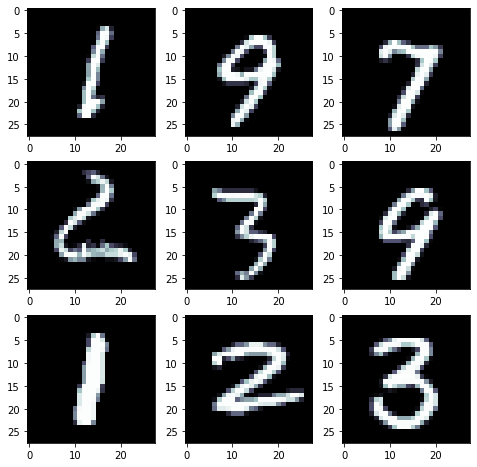

In [27]:
# Get the observation
image, digit = mnist_train[0]

print(f'Shape of image: {image.shape} '
      f'| MNIST Number: {digit} '
      f'| Requires Grad: {image.requires_grad}')

# Plot
fig, ax = plt.subplots(3, 3, figsize=(8, 8))

# Grab some random integers
idx = np.random.randint(1000, size=9)

curr_idx = 0

# Plot images in a grid
for ii in [0, 1, 2]:
    for jj in [0, 1, 2]:
        image, digit = mnist_train[idx[curr_idx]]
        ax[ii, jj].imshow(image.squeeze(), cmap='bone')
        curr_idx += 1

# Creating the convolutional neural network

- Within this class we will be creating a CNN for MNIST
- This network will have 2 convolutional layers and 2 linear (dense) layers

We are going to build our network by looking at the [PyTorch Documentation](https://pytorch.org/docs/stable/nn.html)

**Specifically our network will use**

* `nn.Con2d()`: 2-dimensional convolutions
* `nn.MaxPool2d()`: 2-dimensional maxpooling (~downsampling/dim reduction along the way)
* `nn.ReLU()`: Activation function
* `nn.Flatten()`: To flatten our 2-dimensional data
* `nn.Linear()`: Linear layers 
* `nn.LogSoftmax()`: Multiclass prediction probability normalization (0-1)

**First Convolution Layer**
- 2d convolution of in(1), out(2), kernel size(4)
- 2d maxpooling (2,2)
- Activation function

**Second Convolution Layer**
- 2d convolution of in(2), out(4), kernel size(4)
- 2d maxpooling (2,2)
- Activation function

**Linear Layer**
- Go from 2d to 1d
- Linear layer of in(64), out(10)
- Multiclass prediction probability normalization

In [28]:
class CNN_MNIST(nn.Module):
    
    def __init__(self):
        nn.Module.__init__(self)
        
        self.model = nn.Sequential(
            # Convolution layer 1
            nn.Conv2d(1, 2, kernel_size=4),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            
            # Convolution layer 2
            nn.Conv2d(2, 4, kernel_size=4),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            
            # Linear layer
            nn.Flatten(),
            nn.Linear(64, 10),
            nn.LogSoftmax()
        )

9. What is the primary purpose of pooling?
    - [ ] Include non-linear functions to our data
    - [ ] Capture nuanced aspects of our imaging data (lines, edges, loops)
    - [x] Reduce the dimensionality
    - [ ] Split kernels into similar groupings

# Lets train the network!

<font color='red'>Note</font>: this is CPU intensive, and you dont want to set your epochs to high (~3-10 should be enough)

In [30]:
# Create an instance of our mnist cnn
net = CNN_MNIST()

# Learning rate
lr = .001

# Number of epochs to train for
n_epochs = 5

# Create our optimizer
optimizer = optim.Adam(net.parameters(), lr=lr)

print('Initializing Network...\n')

# Store overall performance
train_loss_tot = []
test_loss_tot = []

train_acc_tot = []
test_acc_tot = []

for epoch in range(5):
    train_loss_arr = []
    test_loss_arr = []
    
    # Training set and weight updating
    for batch_idx, (data, target) in enumerate(tqdm(mnist_train_loader, leave = False)):
            
            # Zero the gradient
            optimizer.zero_grad() 
            
            # Forward pass
            output = net.model(data)
            
            # Compute loss
            loss = F.nll_loss(output, target)
            
            # Backprop and step
            loss.backward()
            optimizer.step()
            
            # Store loss and accuracy
            train_loss_arr.append(loss.item())
            train_acc_tot.append((output.argmax(dim = 1) == target).sum() / target.shape[0])
    
    # Test evaluation
    with torch.no_grad():
        for test_batch_idx, (test_data, test_target) in enumerate(mnist_test_loader):
            
            # Forward pass (get prediction)
            test_output = net.model(test_data)
            
            # Compute loss
            test_loss = F.nll_loss(test_output, test_target)
            
            # Store loss and accuracy
            test_loss_arr.append(test_loss.item())
            test_acc_tot.append((test_output.argmax(dim = 1) == test_target).sum()
                                / test_target.shape[0])
    
    
    train_loss_tot.append(np.mean(np.array(train_loss_arr)))
    test_loss_tot.append(np.mean(np.array(test_loss_arr)))
    
    print(f'Epoch: {epoch+1} '
          f'| Train Loss: {train_loss_tot[-1]:.4f} | Train Acc: {train_acc_tot[-1]:.2f} '
          f'| Test Loss: {test_loss_tot[-1]:.4f} | Test Acc: {test_acc_tot[-1]:.2f}')

Initializing Network...



  0%|          | 0/938 [00:00<?, ?it/s]/opt/conda/lib/python3.9/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 1 | Train Loss: 0.5203 | Train Acc: 0.97 | Test Loss: 0.2103 | Test Acc: 0.94


Epoch: 2 | Train Loss: 0.2004 | Train Acc: 0.94 | Test Loss: 0.1679 | Test Acc: 0.95


Epoch: 3 | Train Loss: 0.1684 | Train Acc: 0.94 | Test Loss: 0.1506 | Test Acc: 0.95


Epoch: 4 | Train Loss: 0.1527 | Train Acc: 0.97 | Test Loss: 0.1418 | Test Acc: 0.96


Epoch: 5 | Train Loss: 0.1408 | Train Acc: 0.94 | Test Loss: 0.1261 | Test Acc: 0.97


# Create a fully connected layer for the network

- Lets compare the performance of the CNN against a network with no convolutions

**Network Structure**

1. Data needs to be 1D (need to flatten)
2. linear layer with (in = our data dim flattened, out = 10)
3. ReLU activation
4. linear layer with (in = 10, out = 10)
5. ReLU activation
6. linear layer with (in = 10, out = 10)
7. LogSoftMax 

In [41]:
class Dense_MNIST(nn.Module):
    
    def __init__(self):
        nn.Module.__init__(self)
        
        self.model = nn.Sequential(
            nn.Flatten(),
            
            # Layer 1
            nn.Linear(28*28, 10),
            nn.ReLU(),
            
            # Layer 2
            nn.Linear(10, 10),
            nn.ReLU(),
            
            # Layer 3
            nn.Linear(10, 10),
            nn.LogSoftmax()
        )

**Now rerun with the dense network below**

In [42]:
# Create an instance of our mnist cnn
net = Dense_MNIST()

# Learning rate
lr = .001

# Number of epochs to train for
n_epochs = 5

# Create our optimizer
optimizer = optim.Adam(net.parameters(), lr=lr)

print('Initializing Network...\n')

# Store overall performance
train_loss_tot = []
test_loss_tot = []

train_acc_tot = []
test_acc_tot = []

for epoch in range(5):
    train_loss_arr = []
    test_loss_arr = []
    
    # Training set and weight updating
    for batch_idx, (data, target) in enumerate(tqdm(mnist_train_loader, leave = False)):
            
            # Zero the gradient
            optimizer.zero_grad() 
            
            # Forward pass
            output = net.model(data)
            
            # Compute loss
            loss = F.nll_loss(output, target)
            
            # Backprop and step
            loss.backward()
            optimizer.step()
            
            # Store loss and accuracy
            train_loss_arr.append(loss.item())
            train_acc_tot.append((output.argmax(dim = 1) == target).sum() / target.shape[0])
    
    # Test evaluation
    with torch.no_grad():
        for test_batch_idx, (test_data, test_target) in enumerate(mnist_test_loader):
            
            # Forward pass (get prediction)
            test_output = net.model(test_data)
            
            # Compute loss
            test_loss = F.nll_loss(test_output, test_target)
            
            # Store loss and accuracy
            test_loss_arr.append(test_loss.item())
            test_acc_tot.append((test_output.argmax(dim = 1) == test_target).sum()
                                / test_target.shape[0])
    
    
    train_loss_tot.append(np.mean(np.array(train_loss_arr)))
    test_loss_tot.append(np.mean(np.array(test_loss_arr)))
    
    print(f'Epoch: {epoch+1} '
          f'| Train Loss: {train_loss_tot[-1]:.4f} | Train Acc: {train_acc_tot[-1]:.2f} '
          f'| Test Loss: {test_loss_tot[-1]:.4f} | Test Acc: {test_acc_tot[-1]:.2f}')

Initializing Network...



  0%|          | 0/938 [00:00<?, ?it/s]/opt/conda/lib/python3.9/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 1 | Train Loss: 0.6457 | Train Acc: 0.88 | Test Loss: 0.3617 | Test Acc: 0.90


Epoch: 2 | Train Loss: 0.3475 | Train Acc: 0.88 | Test Loss: 0.3136 | Test Acc: 0.91


Epoch: 3 | Train Loss: 0.2956 | Train Acc: 0.94 | Test Loss: 0.2716 | Test Acc: 0.93


Epoch: 4 | Train Loss: 0.2603 | Train Acc: 1.00 | Test Loss: 0.2561 | Test Acc: 0.94


Epoch: 5 | Train Loss: 0.2380 | Train Acc: 0.97 | Test Loss: 0.2419 | Test Acc: 0.92


**How does this network compare with our CNN?**
> This network seems to overfit, reaching perfect training accuracy but lower test accuracy.

10. What might be happening and why is the convolutional neural network acheiving higher test accuracy?
    - [ ] The added weight decay allows us to uncover variability in pixel intensity
    - [ ] The network without convolutions has too many layers and is suffering from gradient vanishing
    - [ ] The CNN allows us to uncover low level features and relationships among these 
    - [x] The CNN has substantially fewer trainable parameters and may be able to generalize better
    - [x] Flattening our 2D images obscures context embedded in native 2D space